**Imports**

In [108]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from matplotlib import gridspec, lines, legend_handler
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as scs
from scipy import ndimage
from statsmodels.formula.api import ols
from os import path
from io import StringIO
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.collections import LineCollection
from matplotlib.patches import Patch
from cycler import cycler
import warnings
import itertools

from python_scripts.utils import loc_utils as lut
from python_scripts.utils import vis_utils as vut
from python_scripts.utils.vis_utils import gcolors, glabels, fullglabels, gmarkers, colors, ncolors, tlabels
from python_scripts.utils.model_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Activity choices in different NAM groups

In [ ]:
def make_fig(data_path, nam_data_path, figname, save_to, save_as=None):
    # Load data
    df = pd.read_csv(data_path).filter(items=['sid','group','trial','activity'])
    
    # Select only required free-play trials (N = 250)
    df = df.loc[df.trial.le(60+250) & df.trial.gt(60), :]
    nam_df = pd.read_csv(nam_data_path).filter(items=['sid','nam']).set_index('sid')
    df = df.dropna().drop(columns='trial')
    df = df.merge(nam_df, on='sid')
    df = df.loc[df.nam.gt(0), :]
    
    # Count trials per activity for each subject
    counts = df.groupby(['group', 'nam', 'sid']).activity.value_counts().to_frame('counts')
    counts = 100*counts / counts.groupby(['group', 'nam', 'sid']).transform('sum')
    counts_stats = counts.groupby(['group','nam','activity']).agg(['mean', 'sem'])
    counts_stats.columns = counts_stats.columns.droplevel(0)
    display(counts_stats)

    fig = plt.figure(figname, figsize=[8, 3])
    for nam in [1,2,3]:
        ax = vut.pretty(fig.add_subplot(1,3,nam), 'y')
        ax.axhline(25, ls='--', color='k', alpha=.8)
        x = np.array([1, 2, 3, 4])
        for i, group in enumerate([1, 0]):
            x_ = x+[-.1, .1][group]
            y = counts_stats.loc[(group, nam, slice(None)), 'mean']
            yerr = counts_stats.loc[(group, nam, slice(None)), 'sem']
            ax.errorbar(x_, y, yerr=yerr, color=gcolors[group], marker=gmarkers[group],
                        capsize=5, markersize=8, lw=2, label=fullglabels[group])
        ax.set_ylim(10, 57)
        ax.set_xticks(x)
        ax.set_xticklabels(['A1', 'A2', 'A3', 'A4'], fontsize=12, fontweight='bold')
        for xt, c in zip(ax.get_xticklabels(), colors):
            xt.set_color(c)
        
        ax.set_title('NAM {}'.format(nam), fontsize=12)
        if nam == 1: 
            ax.set_ylabel('Trials per activity\n(%; Mean and SEM)', fontsize=12)
        if nam == 2: 
            ax.set_xlabel('Learning activity'.format(nam), fontsize=12)
        
    leg = ax.legend(fontsize=12)

    fig.tight_layout()
    if save_as:
        vut.save_it(fig, save_to, figname, save_as=save_as, compress=False)


make_fig(
    data_path = 'data/clean_data.csv',
    nam_data_path = 'data/nam_data.csv',
    figname = 'choices_by_nam',
    save_to = 'figures',
    save_as = '' # File format (png, jpeg, svg, ...)
)

# Coefficients and behavior

|Effect size|*d*|
|---|---|
|Very small|0.01|
|Small|0.20|
|Medium|0.50|
|Large|0.80|
|Very large|1.20|
|Huge|2.0|

<IPython.core.display.Javascript object>


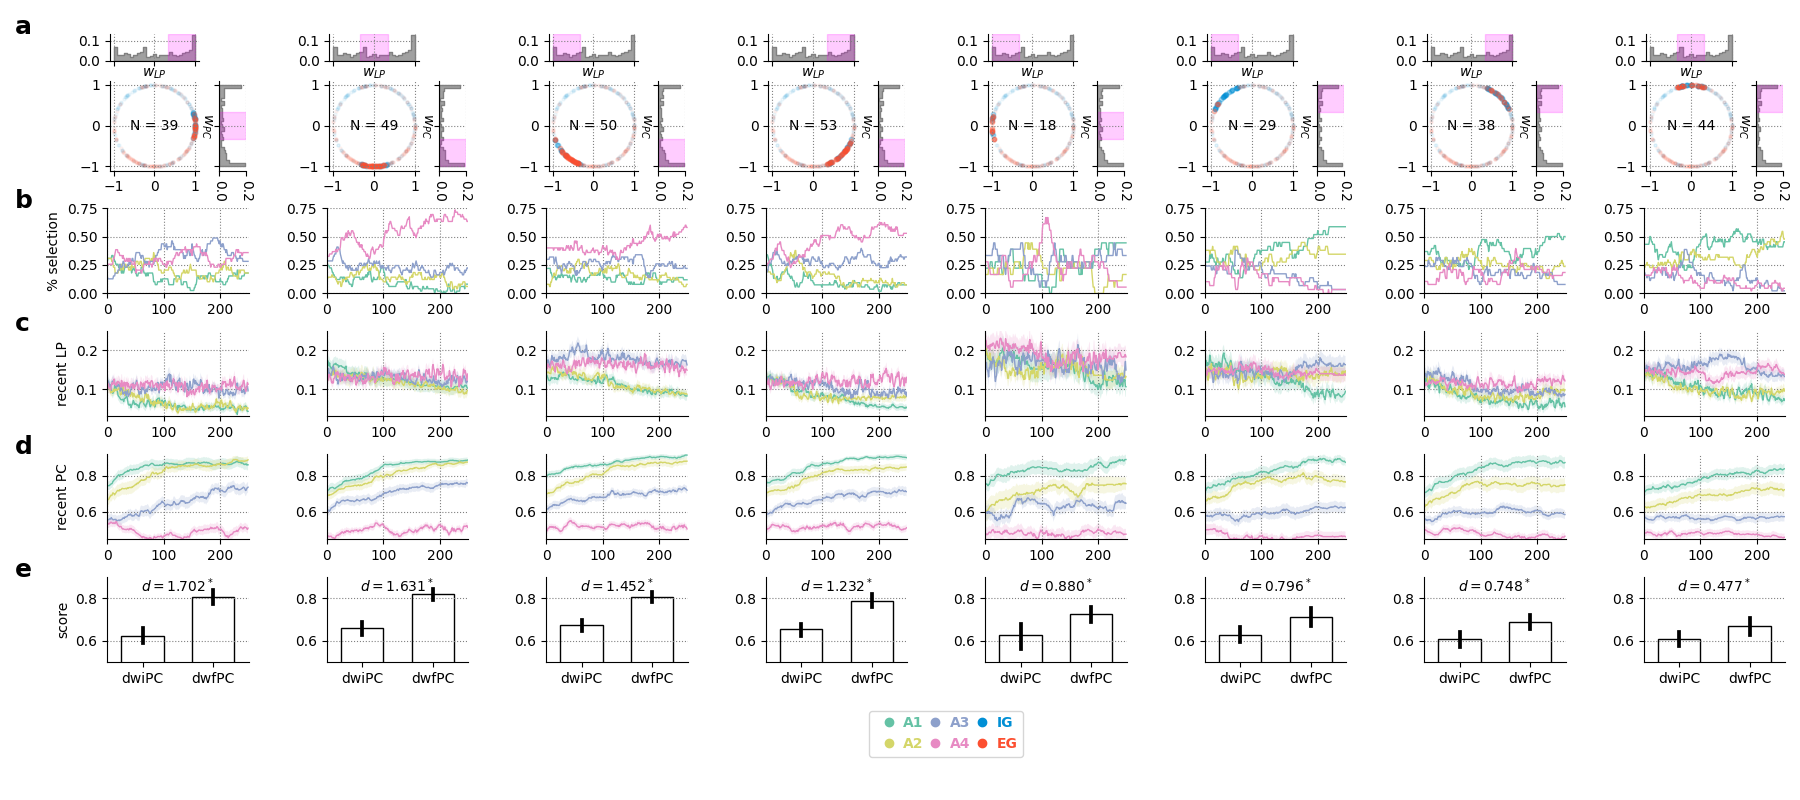

SAVED TO: figures/smfig1.png


In [313]:
def load_data(heuristics_data_path, params_data_path, learning_data_path, nq=1, nam=None):
    idx = pd.IndexSlice
    # Heuristics dataset
    hdf = pd.read_csv(heuristics_data_path)
    # Params dataset
    pdf = pd.read_csv(params_data_path)
    pdf = pdf.loc[pdf.vars.eq('rpc,rlp'), :]
    # Learning dataset
    ldf = pd.read_csv(learning_data_path)
    # Optionally, filter by NAM
    if nam: 
        hdf = df.loc[hdf.nam.eq(nam), :]
        pdf = df.loc[pdf.nam.eq(nam), :]
    # Get normalized coefficient values and label quantiles
    norm = np.linalg.norm(pdf.loc[:, 'rpc':'rlp'].values, axis=1)
    pdf['norm_rpc'] = pdf.rpc / norm
    pdf['norm_rlp'] = pdf.rlp / norm
#     pdf['qi_rpc'] = pd.qcut(pdf.norm_rpc, q=nq)
#     pdf['qi_rlp'] = pd.qcut(pdf.norm_rlp, q=nq)
    pdf['qi_rpc'] = pd.cut(pdf.norm_rpc, bins=nq)
    pdf['qi_rlp'] = pd.cut(pdf.norm_rlp, bins=nq)
    # Select columns in each df
    pcols = ['sid','group','nam','rpc', 'rlp', 'norm_rpc', 'norm_rlp', 'qi_rpc', 'qi_rlp']
    hcols = ['sid', 'group', 'trial'] + [i for sub in [[v+si for si in '1234'] for v in ['rpc', 'rlp', 'ch']] for i in sub]
    lcols = ['sid', 'dwfpc', 'dwipc']
    return {'p': pdf.filter(items=pcols), 'h': hdf.filter(items=hcols), 'l': ldf.filter(items=lcols)}


def subfig_a(axes, df, qi_rlp, qi_rpc, bins=25):
    # Get quantile bracket
    qrlp = df.qi_rlp.unique()[qi_rlp]
    qrpc = df.qi_rpc.unique()[qi_rpc]
    # Plot joint data
    for group in [0, 1]:
        ax = axes[1]
        grp_flt = df.group.eq(group)
        q_flt = df.qi_rlp.eq(qrlp) & df.qi_rpc.eq(qrpc)
        ax.scatter(
            df.loc[grp_flt & ~q_flt, 'norm_rlp'],
            df.loc[grp_flt & ~q_flt, 'norm_rpc'],
            alpha=.05, color=gcolors[group], marker='o', s=5)
        ax.scatter(
            df.loc[grp_flt & q_flt, 'norm_rlp'],
            df.loc[grp_flt & q_flt, 'norm_rpc'],
            alpha=.3, color=gcolors[group], marker='o', s=10)
    ax.text(0, 0, 'N = {:}'.format(q_flt.sum()), ha='center', va='center')
#         display(df.groupby('group')[['norm_rpc','norm_rlp']].agg(['mean','sem']))
    # Plot marginal data
    sns.histplot(x='norm_rlp', data=df, ax=axes[0], stat='probability', bins=bins, element='step', color='gray')
    axes[0].axvspan(qrlp.left, qrlp.right, color='magenta', alpha=.2)
    sns.histplot(y='norm_rpc', data=df, ax=axes[2], stat='probability', bins=bins, element='step', color='gray')
    axes[2].axhspan(qrpc.left, qrpc.right, color='magenta', alpha=.2)
    # Labels
    for ax in (axes[0], axes[2]):
        ax.set_xlabel('')
        ax.set_ylabel('')
    axes[0].tick_params(labelbottom=False)
    axes[2].tick_params(labelleft=False, labelrotation=-90)
    axes[0].set_xlabel(r'$w_{LP}$')
    axes[2].set_ylabel(r'$w_{PC}$', rotation=-90, va='top')


def subfig_var(ax, df, variable, errb=False, sample_size=False, lw=2):
    idx = pd.IndexSlice
    ax.set_prop_cycle(cycler(color=colors))
    grouped = df.groupby('trial').agg(['mean', 'sem'])
    s = (variable+'{}').format
    y = grouped.loc[:, idx[s(1):s(4), 'mean']].values
    x = np.stack([np.arange(y.shape[0]) for i in range(y.shape[1])], axis=1)
    yerr = grouped.loc[:, idx[s(1):s(4), 'sem']].values
    ax.plot(x, y, lw=1)
    if errb:
        for i in range(x.shape[1]):
            ax.fill_between(x[:, i], y1=y[:, i]+yerr[:, i], y2=y[:, i]-yerr[:, i], alpha=.2)
    ax.set_xlim(0, 250)
    if sample_size:
        ax.set_title('N = {}'.format(len(df.sid.unique())))

        
def subfig_stats(ax, df):
    t, pval = scs.ttest_rel(df.dwipc, df.dwfpc)
    d = (df.dwfpc.mean() - df.dwipc.mean()) / np.sqrt((df.dwfpc.std()**2 + df.dwipc.std()**2)/2)
    df = df.melt()
    df = df.replace({'dwfpc': 'dwfPC', 'dwipc': 'dwiPC'})
    sns.barplot(
        x='variable', y='value', data=df, order=['dwiPC', 'dwfPC'], ax=ax,
        linewidth=1, facecolor=(1, 1, 1, 0), errcolor='k', edgecolor='k'
    )
    ax.text(.5, .90, r'$d={:.3f}^*$'.format(d, pval), va='top', ha='center')
    ax.set_xlabel(''); ax.set_ylabel('')
    vut.change_width(ax, .6)
    

def make_fig(nq, figname, save_to, save_as=''):
    nrows, ncols = 5+1, nq**2-1
    fig = plt.figure(num=figname, figsize=[2 + 2*ncols, 8])
    subfig_ratios = [.7, .4]
    gs = fig.add_gridspec(
        ncols = 1 + ncols, 
        nrows = nrows, 
        width_ratios = [.1] + list(np.ones(ncols)),
        height_ratios = [2] + list(np.ones(nrows-1) + [.25])
    )
    add = fig.add_subplot
    
    # Load data
    data = load_data(
        heuristics_data_path = 'data/model_data.csv',
        params_data_path = 'data/model_results/param_fits_clean.csv',
        learning_data_path = 'data/learning_data.csv',
        nam = None,
        nq = nq
    )
    
    # Annotate figure rows
    for i, letter in enumerate('abcde'):
        vut.add_subplot_label(x=0, y=1, label=letter, size=18, ax=fig.add_subplot(gs[i, 0]))
    
    # Plot data
    qs_rlp = data['p'].qi_rlp.unique()
    qs_rpc = data['p'].qi_rpc.unique()
    for ci, (i, j) in enumerate(zip([0,1,2,0,2,2,0,1], [0,2,2,2,0,1,1,1]), 1):
        # Subplot (a)
        main_ax = vut.pretty(add(gs[0, ci], aspect='equal'))
        divider = make_axes_locatable(main_ax)
        marg_ax1 = vut.pretty(divider.append_axes('top', '30%', pad=0.2, sharex=main_ax))
        marg_ax2 = vut.pretty(divider.append_axes('right', '30%', pad=0.2, sharey=main_ax))
        axes = [marg_ax1, main_ax, marg_ax2]
        subfig_a(axes, data['p'], qi_rlp=i, qi_rpc=j)

        # Filter sids for subplots (b) to (e)
        sids = data['p'].loc[
                data['p'].qi_rlp.eq(qs_rlp[i]) & data['p'].qi_rpc.eq(qs_rpc[j])
            ].sid.unique()

        # Select data for subplots (b) to (d)
        df = data['h'].set_index('sid').loc[sids, :].reset_index()

        # Subplot (b)
        ax = vut.pretty(add(gs[1, ci]))
        subfig_var(ax, df, variable='ch', errb=False)
        ax.set_ylim(0, 0.75)
        if ci == 1: 
            ax.set_ylabel('% selection')

        # Subplot (c)
        ax = vut.pretty(add(gs[2, ci]))
        subfig_var(ax, df, variable='rlp', errb=True)
        ax.set_ylim(0.03, 0.25)
        if ci == 1:
            ax.set_ylabel('recent LP')

        # Subplot (d)
        ax = vut.pretty(add(gs[3, ci]))
        subfig_var(ax, df, variable='rpc', errb=True)
        ax.set_ylim(0.45, 0.92)
        if ci == 1:
            ax.set_ylabel('recent PC')

        # Select data for subplots (e)
        df = data['l'].set_index('sid').loc[sids, :]

        # Subplot (e)
        ax = vut.pretty(add(gs[4, ci]))
        subfig_stats(ax, df)
        ax.set_ylim(.5, .9)
        if ci == 1:
            ax.set_ylabel('score')
            
    # Add legend
    ax = vut.ghost(add(gs[5, 1:]))
    handles = [lines.Line2D([0], [0], color=colors[k], ls='', marker='o', label=tlabels[k + 1]) for k in range(4)]
    handles += [lines.Line2D([0], [0], ls='', marker='o', markerfacecolor=c, markeredgecolor=c, color=c) for c in gcolors]
    legw, legh = .1, .2
    leg = ax.legend(handles, list(tlabels.values())+list(fullglabels.values()), handletextpad=.05,
                    bbox_to_anchor=(.5-legw/2, .5, legw, legh), loc='center', mode='expand', ncol=3)
    vut.color_legend(leg)

    fig.tight_layout()
    fig.subplots_adjust(hspace=.4)
    if save_as:
        vut.save_it(fig, save_to, figname=figname, save_as=save_as, compress=False, dpi=100)
    
    
make_fig(
    nq = 3,
    figname = 'smfig1',
    save_to = 'figures',
    save_as = 'png' # File format (png, jpeg, svg, ...)
)

# Proportion of correct responses over time

In [ ]:
def make_bottom_fig(data_path, figname, save_to, save_as=None):
    # Load data, select columns
    df = pd.read_csv(data_path)[['sid','group','trial','correct']]
    
    # Select free-play trials
    df = df.loc[(df.trial <= 60+250) & (df.trial > 60)]
    df.loc[:, 'trial'] -= 60
    
    # Calculate percentage of subjects who guessed correctly for each trial in each group
    df = df.groupby(['group', 'trial'])[['correct']].mean()
    df.loc[:, 'correct'] = df.correct * 100
    
    # Fit linear regression (set EG for contrast reference)
    lm = ols('correct ~ trial*C(group,Treatment(reference=1))', data=df.reset_index()).fit()
    params = lm.params
    display(lm.summary())

    # Make figure
    fig = plt.figure(figname, figsize=[5, 3])
    ax = vut.pretty(fig.add_subplot(111))

    for grp in [0, 1]:
        # Display raw percentages
        x = np.arange(1, 251)
        y = df.loc[(grp, slice(None)), :].values.squeeze()
        ax.plot(x, y, color=gcolors[grp], ls='', alpha=.3, marker='.')
        
        # Display model predictions 
        x_ = np.array([1, 251])
        y_ = lm.predict({'group': (grp, grp), 'trial': x_})
        ax.plot(x_, y_, color=gcolors[grp], lw=2, alpha=.9, label=fullglabels[grp])
        
        # Print fitted line equations
        intercept = params[0] + params[1] * grp
        slope = params[2] + params[3] * grp
        pos = int(slope > 0)
        txt = 'Y = {:.3f} {} {:.3f}*X'.format(intercept, '-+'[pos], np.abs(slope))
        print('group {}: {}'.format(grp, txt))

    ax.set_xlabel('Trial', fontsize=14)
    ax.set_ylabel('% correct', fontsize=14)

    leg = ax.legend(fontsize=14, ncol=2)
    vut.color_legend(leg)

    ax.set_ylim(55, 85)
    ax.set_xlim(1, 250)
    fig.tight_layout()

    if save_as:
        vut.save_it(fig, save_to, figname, save_as=save_as, compress=False)
        

make_bottom_fig(
    data_path='data/clean_data.csv',
    figname='figure2b_bottom',
    save_to='figures',
    save_as='' # File format (png, jpeg, svg, ...)
)

# Self-challenge index

## Relationship with flat final performance

In [ ]:
def make_fig(data_path, figname, save_to, save_as=''):
    df = pd.read_csv(data_path)
    df = df.loc[df.nam > 0, :]

    propS = np.sum(df.group == 1) / df.shape[0]

    fig = plt.figure(figname, figsize=[7, 7])
    gs = gridspec.GridSpec(2, 2)

    # Make figure (scatter plot and histograms)
    ghost_top = fig.add_subplot(gs[0, 0])
    ghost_top.set_ylabel('Relative frequency', fontsize=14, labelpad=30)
    ghost_top.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    for spine in ghost_top.spines.values(): spine.set_visible(False)

    ax_top1 = vut.pretty(inset_axes(ghost_top, width='100%', height='30%', loc=9, borderpad=0))
    ax_top2 = vut.pretty(inset_axes(ghost_top, width='100%', height='30%', loc=10, borderpad=0))
    ax_top3 = vut.pretty(inset_axes(ghost_top, width='100%', height='30%', loc=8, borderpad=0))

    ghost_right = fig.add_subplot(gs[1, 1])
    ghost_right.set_xlabel('Relative frequency', fontsize=14, labelpad=30)
    ghost_right.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    for spine in ghost_right.spines.values(): spine.set_visible(False)
    ax_right1 = vut.pretty(inset_axes(ghost_right, width='30%', height='100%', loc=6, borderpad=0))
    ax_right2 = vut.pretty(inset_axes(ghost_right, width='30%', height='100%', loc=10, borderpad=0))
    ax_right3 = vut.pretty(inset_axes(ghost_right, width='30%', height='100%', loc=7, borderpad=0))

    ax_scat = vut.pretty(fig.add_subplot(gs[1, 0]))

    bins = np.arange(0, 1.02, .1)
    labels = {'nam': ['NAM ' + str(i) for i in (0, 1, 2, 3)], 'group': fullglabels}
    axes_by_nam = {
        'top': {
            3: ax_top1,
            2: ax_top2,
            1: ax_top3},
        'right': {
            1: ax_right1,
            2: ax_right2,
            3: ax_right3}}
    for nam in [1, 2, 3]:
        axes_by_nam['top'][nam].set_xlim(.0, .8)
        axes_by_nam['top'][nam].set_ylim(0., .4)
        axes_by_nam['right'][nam].set_xlim(0., .45)
        axes_by_nam['right'][nam].set_ylim(0.38, 1.)
        for group in [0, 1]:
            x = df.loc[(df.nam == nam) & (df.group == group), 'sc_lep']
            y = df.loc[(df.nam == nam) & (df.group == group), 'fpc']
            ax_scat.scatter(x, y, s=30, alpha=.7,
                            facecolors=ncolors[nam - 1] if group else 'w',
                            edgecolors=ncolors[nam - 1])

            rf, _ = np.histogram(x, bins=bins, weights=np.ones_like(x) / x.size)
            axes_by_nam['top'][nam].plot(bins[:-1], rf, c=ncolors[nam - 1], lw=2,
                                         ls='-' if group else '--',
                                         label='{} / NAM-{}'.format(glabels[group], nam))
            axes_by_nam['top'][nam].tick_params(labelbottom=False)
            axes_by_nam['top'][nam].text(.02, .9, 'NAM-{}'.format(nam), ha='left', va='top', fontsize=12,
                                         color=ncolors[nam - 1], transform=axes_by_nam['top'][nam].transAxes)

            rf, _ = np.histogram(y, bins=bins, weights=np.ones_like(x) / x.size)
            axes_by_nam['right'][nam].plot(rf, bins[1:], c=ncolors[nam - 1], lw=2,
                                           ls='-' if group else '--',
                                           label='{} / NAM-{}'.format(glabels[group], nam))
            axes_by_nam['right'][nam].tick_params(labelleft=False)
            axes_by_nam['right'][nam].text(.95, .02, 'NAM-{}'.format(nam), ha='right', va='bottom', fontsize=12,
                                           color=ncolors[nam - 1], transform=axes_by_nam['right'][nam].transAxes)

    ax_scat.set_xlim(.0, .8)
    ax_scat.set_ylim(0.38, 1.)
    ax_scat.set_xlabel('Self-challenge (SC)', fontsize=14)
    ax_scat.set_ylabel('Mean performance', fontsize=14)

    # Edit legend
    c = 'darkgray'
    mark_ig = lines.Line2D([0], [0], ls='', marker='o', label=fullglabels[0], markerfacecolor='w', markeredgecolor=c)
    line_ig = lines.Line2D([0], [0], color=c, lw=2, label=fullglabels[0], ls='--', dashes=(2, 1))

    mark_eg = lines.Line2D([0], [0], color=c, ls='', marker='o', label=fullglabels[1])
    line_eg = lines.Line2D([0], [0], color=c, lw=2, label=fullglabels[1])

    ax_scat.legend(((line_ig, mark_ig), (line_eg, mark_eg)), fullglabels.values(),
                   bbox_to_anchor=(.5, 1.1,),
                   fontsize=12, ncol=3, loc='center',
                   handler_map={tuple: legend_handler.HandlerTuple(ndivide=None)})

    # Plot line of best fit for unstandardized data
    qreg = ols('fpc ~ (ipc + {0} + np.power({0}, 2) + group)'.format('sc_lep'), data=df).fit()
    x = np.linspace(df.loc[:, 'sc_lep'].min(), df.loc[:, 'sc_lep'].max(), 100)
    y_hat = qreg.get_prediction({'sc_lep': x,
                                 'ipc': np.full_like(x, df.dwipc.mean()),
                                 'group': np.full_like(x, propS)
                                 }).summary_frame()
    display(y_hat.head())
    c, alpha = 'k', .7
    ax_scat.plot(x, y_hat['mean'], c=c, alpha=alpha)
    ax_scat.plot(x, y_hat['mean_ci_lower'], c=c, lw=1, ls='--', alpha=alpha)
    ax_scat.plot(x, y_hat['mean_ci_upper'], c=c, lw=1, ls='--', alpha=alpha)
    
    # Run quadratic regression of final performance
    df.loc[:, 'sc_lep'] = scs.stats.zscore(df.loc[:, 'sc_lep']) # Standardize x before fitting the quadratic model
    qreg = ols('fpc ~ ipc + group + sc_lep + np.power(sc_lep, 2)', data=df).fit()
    display(qreg.summary())
    
    # Run nonquadratic regression and compare AIC
    nonqreg = ols('fpc ~ (ipc + sc_lep + group)', data=df).fit()
    print('Delta AIC = {:.2f}'.format(qreg.aic - nonqreg.aic))

    # Run model of average SC as a function of Group x NAM
    lreg = ols('sc_lep ~ C(group) * C(nam)', data=df).fit()
    display(lreg.summary())
    
    # Show group and subgroup counts
    display(df.groupby(['group', 'nam'])['sid'].agg('count'))
    
    # Save figure
    fig.tight_layout()
    if save_as:
        vut.save_it(fig, save_to, figname=figname, save_as=save_as, compress=False, dpi=100)


make_fig(
    data_path = 'data/learning_data.csv',
    figname = 'figure3',
    save_to = 'figures',
    save_as = 'png' # File format (png, jpeg, svg, ...)
)

## Relationship with activity choices

In [ ]:
def main(model_data_path, learning_data_path, figname, save_to, save_as=''):
    # Load data
    df = pd.read_csv(model_data_path, index_col='sid')
    df = df.filter(items='trial,relt1,relt2,relt3,relt4'.split(',')).set_index('trial', append=True)
    df = df.loc[(slice(None), 250), :]
#     df = df * (250+60) - 15
    df.index = df.index.droplevel(1)
    df = df.rename(columns={'relt1':'A1','relt2':'A2','relt3':'A3','relt4':'A4'})
    
    df = df.merge(pd.read_csv(learning_data_path, index_col='sid').filter(items=['sc_lep']), on='sid')
    display(df.head())
    
    fig = plt.figure(num=figname, figsize=[8, 8])
    gs = GridSpec(4, 4)
    
    ghost = fig.add_subplot(111)
    ghost.set_title('Correlations of activity preferences with average SC', pad=10)
    ghost.set_ylabel('Average SC', fontsize=14, labelpad=35)
    ghost.set_xlabel('Choice preference', fontsize=14, labelpad=30)
    ghost.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    for spine in ghost.spines.values(): 
        spine.set_visible(False)
    
    for i, act1 in enumerate(['A1','A2','A3','A4']):
        for j, act2 in enumerate(['A1','A2','A3','A4']):
            ax = vut.pretty(fig.add_subplot(gs[i, j]))
#             ax.set_xlim(-250, 250)
            ax.set_ylim(0, 1)
            if i != 3:
                ax.tick_params(labelbottom=False)
            if j:
                ax.tick_params(labelleft=False)
            if i == j:
                plt.axis('off')
                continue
            else:
                x = df.loc[:, act1] - df.loc[:, act2]
                y = df.loc[:, 'sc_lep']
                ax.scatter(x, y, s=3, alpha=.3, color=gcolors[0])
#                 m, b = np.polyfit(x, y, 1)
#                 plt.plot(x, m*x + b, color=gcolors[1])
                ax.text(0, .83, '{} - {}'.format(act1, act2), ha='center')
        
    if save_as:
        vut.save_it(fig, save_to, figname=figname, save_as=save_as, compress=False, dpi=100)
    

main(
    model_data_path = 'data/model_data.csv',
    learning_data_path = 'data/learning_data.csv',
    figname = 'sc_and_activity_preferences',
    save_to = 'figures',
    save_as = 'png' # File format (png, jpeg, svg, ...)
)

# Self-reports

## Average ratings by instruction and NAM

In [ ]:
def make_fig(data_path, nam_data_path, item, norm, figname, save_to, save_as=None):
    # Load data
    df = pd.read_csv(data_path)
    df = df.merge(pd.read_csv(nam_data_path).loc[:, ('sid', 'nam')], on='sid')
    df = df.loc[df.item.eq(item) & df.nam.gt(0), :]
    
    if norm:
        df.loc[:, 'rating'] = df.rating_norm
        df.drop(columns='rating_norm', inplace=True)
    
    # Calculate average scores
    df = df.groupby(['group','nam','activity'])[['rating']].agg(['mean', 'sem'])
    df.columns = df.columns.droplevel(0)
    display(df)
    
    # Plot results
    fig = plt.figure(figname, figsize=[8, 3])
    for nam in [1,2,3]:
        ax = vut.pretty(fig.add_subplot(1, 3, nam), 'y')
        x = np.array([1, 2, 3, 4])
        for i, grp in enumerate([1, 0]):
            x_ = x+[-.1, .1][grp]
            y = df.loc[(grp, nam, slice(None)), 'mean']
            yerr = df.loc[(grp, nam, slice(None)), 'sem']
            ax.errorbar(x_, y, yerr=yerr, color=gcolors[grp], marker=gmarkers[grp],
                        capsize=5, markersize=8, lw=2, label=fullglabels[grp])
#         ax.set_ylim(4.2, 8.1)
        ax.set_xticks(x)
        ax.set_xticklabels(['A1', 'A2', 'A3', 'A4'], fontsize=12, fontweight='bold')
        for xt, c in zip(ax.get_xticklabels(), colors):
            xt.set_color(c)
        
        ax.set_title('NAM {}'.format(nam), fontsize=12)
        if nam == 1: 
            ax.set_ylabel('Subjective interest\n(Mean and SEM)', fontsize=12)
        if nam == 2: 
            ax.set_xlabel('Learning activity'.format(nam), fontsize=12)
        
    leg = ax.legend(fontsize=12)

    fig.tight_layout()
    if save_as:
        vut.save_it(fig, save_to, figname, save_as=save_as, compress=False)


make_fig(
    data_path = 'data/combined_extra.csv',
    nam_data_path = 'data/nam_data.csv',
    item = 'time',
    norm = True,
    figname = 'interest_by_nam',
    save_to = 'figures',
    save_as = '' # File format (png, jpeg, svg, ...)
)

## Relationship between time and interest by group

In [ ]:
def prepare_data(data_path, ratings_data_path):
    # Load data of activity choices during free play
    df = pd.read_csv(data_path).filter(items=['sid','nam','trial','abst1','abst2','abst3','abst4'])
    df = df.loc[df.trial.eq(250) & df.nam.gt(0), :].drop(columns='trial')
    df = pd.wide_to_long(df, stubnames='abst', i=['sid','nam'], j='act_ind').reset_index()
    df['activity'] = 'A'+df.act_ind.astype(str)
    df = df.drop(columns='act_ind')
    df = df.rename(columns={'abst': 'time'})
    
    # Merge with interest rating data
    ratings_df = pd.read_csv(ratings_data_path)
    ratings_df = ratings_df.loc[ratings_df.item.eq('int'), :]
    df = df.merge(ratings_df.drop(columns='item'), on=['sid', 'activity'])
    return df


def subplot_a(ax, df):
    for group in [0, 1]:
        x = df.loc[df.group.eq(group), 'time']
        y = df.loc[df.group.eq(group), 'rating_norm']
        sns.regplot(x=x, y=y, color=gcolors[group], 
                    ax=ax, scatter_kws={'alpha': .3, 's': 5})
        ax.set_xlabel('Number of trials')
        ax.set_ylabel('Interest rating\n(Mean centered)')
        
        
def subplot_b(axes, df):
    for group in [0, 1]:
        ax = axes[group]
        for nam in [1, 2, 3]:
            x = df.loc[df.group.eq(group) & df.nam.eq(nam), 'time']
            y = df.loc[df.group.eq(group) & df.nam.eq(nam), 'rating_norm']
            sns.regplot(x=x, y=y, color=ncolors[nam-1], 
                        ax=ax, scatter_kws={'alpha': .3, 's': 5})
        ax.set_ylabel('Interest rating\n(Mean centered)')
        ax.set_xlabel('Number of trials')
        ax.set_title(fullglabels[group], color=gcolors[group], fontweight='bold')
            


def make_fig(modeling_data_path, ratings_data_path, figname, save_to, save_as=None):
    # Load data and create figure
    df = prepare_data(modeling_data_path, ratings_data_path)
    fig = plt.figure(figname, figsize=[9, 3])
    
    # Plot relationship between interest and time by group
    ax = vut.pretty(fig.add_subplot(1,3,1))
    subplot_a(ax, df)
    lm = ols('rating ~ C(group) * time', data=df)
    display(lm.fit().summary())
    
    # Plot relationship between interest and time by NAM in each group
    axes = [vut.pretty(fig.add_subplot(1,3,2)), vut.pretty(fig.add_subplot(1,3,3))]
    subplot_b(axes, df)
    for group in [0, 1]:
        print('==='*20)
        lm = ols('rating ~ C(nam) * time', data=df.loc[df.group.eq(group), :])
        display(lm.fit().summary())
        

    fig.tight_layout()
    if save_as:
        vut.save_it(fig, save_to, figname, save_as=save_as, compress=False)


make_fig(
    modeling_data_path='data/model_data.csv', 
    ratings_data_path='data/combined_extra.csv',
    figname = 'interest_time_reg',
    save_to = 'figures',
    save_as = '' # File format (png, jpeg, svg, ...)
)

# Modeling

## Parameter space redundancy

The interaction between the free parameters in the utility function and the inverse temperature parameter create an inifinite amount of redundancy in the parameter space. That is, there are infinitely many models that have the same likelihood (top figure) but different parameters (middle figure), because the softmax temperature scales all utility components evenly. Thus, for each value of $\tau$ there is a unique combination of the utility parameters that that is as likely as the maximum likelihood model (middle figure). Importantly, if we account for the difference in the scaling factor of $\tau$, all of these maximum likelihood models have the same parameter combination (bottom figure).

In [ ]:
def main(data_path, sid, n_max, n_stop, transform_func, init_dict):
    # Load data
    sdf = lut.get_sdf(data_path, sid)
    
    # Create model
    model = SoftmaxChoiceModel(
        objective = neg_log_likelihood,
        data = sdf,
        init_dict = init_dict,
        hist = True
    )
    
    # Transform data
    model.transform_inp_data(transform_func)
    
    # Fit
    model.n_best_stop(n_stop=n_stop, max_iter=n_max, show_progress=True)
    
    # Get fit data
    df = model.get_hist_df()
    df['aic'] = 2*df['loss'] + 2*(len(model.components) + 1)
    df = df.loc[df.aic.eq(df.aic.min()), :]
    display(df.head())
    df['norm'] = np.linalg.norm(df.loc[:, 'rpc':'rlp'].values, axis=1)
    
    plt.figure(num='tau_redundancy', figsize=[6, 6])
    
    plt.subplot(311)
    plt.title('AIC')
    plt.ticklabel_format(useOffset=False)
    plt.scatter(df.loc[:, 'tau'].values, np.round((df.loc[:, 'aic'].values), 5), alpha=.5)
    plt.axhline(df.loc[:, 'aic'].min(), alpha=.5)

    plt.subplot(312)
    plt.title(r'Fitted parameters relative to $\tau$')
    for i in model.components:
        plt.scatter(df.loc[:, 'tau'].values, df.loc[:, i].values, alpha=.5, label=i)
    plt.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    plt.axhline(0, alpha=.5)

    plt.subplot(313)
    plt.title(r'Absolute values of fitted parameters')
    plt.xlabel(r'Inverse temperature ($\tau$)')
    for i in model.components:
        plt.scatter(df.loc[:, 'tau'].values, df.loc[:, i].values*df.loc[:, 'tau'].values, alpha=.5, label=i)
        
    plt.gca().set_prop_cycle(None)
    for i in model.components:
        plt.scatter(df.loc[:, 'tau'].values, df.loc[:, i].values/df.loc[:, 'norm'].values, alpha=.5, label=i, marker='^')
    
    for i in model.components:
        df.loc[:, i+'_abs'] = df.loc[:, i].values*df.loc[:, 'tau'].values
    display(df.head())
    
    plt.tight_layout()
#     save_it(plt.gcf(), '/Users/alexten/Desktop', figname='tau_redundancy', 
#             save_as='png', compress=False, dpi=100)


main(
    data_path = 'data/model_data.csv',
    sid = -1,
    n_max = 300,
    n_stop = 50,
    transform_func = normalize,
    init_dict = {
        # 'param_handle': (init_range, apply_boundary)
        'rpc':([-1,1], True),
        'rlp':([-1,1], True),
#         'abst':([-1,1], True),
        'tau': ([1,100], True),
    }
)

In [ ]:
origin = [0, 0]
v = np.array([0.274394, 0.788049])
vnorm = np.linalg.norm(v)
tau = 9.878803

plt.figure('norm')
plt.subplot(111, aspect='equal')
plt.axhline(0, lw=1.5, c='k')
plt.axvline(0, lw=1.5, c='k')
plt.xlim(-6,6)
plt.ylim(-6,6)
plt.grid(True)

plt.plot((origin[0], v[0]), 
         (origin[1], v[1]), c='red', ls='', marker='o', markersize=4, alpha=.5)

plt.plot((origin[0], v[0]*tau), 
         (origin[1], v[1]*tau), c='k', ls='', marker='s', markersize=4, alpha=.5)

plt.plot((origin[0], v[0]/vnorm), 
         (origin[1], v[1]/vnorm), c='cyan', ls='', marker='^', markersize=4, alpha=.5)

## Redundancy of caused by multiplicity of components

In [ ]:
def main(data_path, sid, n_max, n_stop, transform_func, init_dict):
    # Load data
    sdf = get_sdf('data/model_data.csv', sid)
    
    # Create model
    model = SoftmaxChoiceModel(
        objective = neg_log_likelihood,
        data = sdf,
        init_dict = init_dict,
        hist = True
    )
    
    # Transform data
    model.transform_inp_data(transform_func)
    
    # Fit
    model.n_best_stop(n_stop=n_stop, max_iter=n_max, show_progress=True)
    
    # Get fit data
    df = model.get_hist_df()
    df['aic'] = 2*df['loss'] + 2*(len(model.components))
    display(df.head())
    
    plt.figure(num='redundancy', figsize=[6, 6])
    
    plt.subplot(311)
    plt.title('AIC')
    plt.ticklabel_format(useOffset=False)
    plt.scatter(df.index.tolist(), np.round((df.loc[:, 'aic'].values), 5), alpha=.5)
    plt.axhline(df.loc[:, 'aic'].min(), alpha=.5)

    plt.subplot(312)
    plt.title(r'Fitted parameters')
    for i in model.components:
        plt.scatter(df.index.tolist(), df.loc[:, i].values, alpha=.5, label=i)
    plt.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    plt.axhline(0, alpha=.5, c='k')

    plt.subplot(313)
    plt.title(r'Fitted parameters normalized by $\sqrt{w_{PC}^2+w_{LP}^2}$')
    plt.xlabel(r'Inverse temperature ($\tau$)')
    norm = df.loc[:, model.components].values
    norm = np.sum(norm**2, axis=1)
    for i in model.components:
        plt.scatter(df.index.tolist(), df.loc[:, i].values/norm, alpha=.5, label=i)
    plt.tight_layout()

    for i in model.components:
        df.loc[:, i+'_abs'] = df.loc[:, i].values*df.loc[:, 'tau'].values
    display(df.head())
    
    save_it(plt.gcf(), '/Users/alexten/Desktop', figname='redundancy', 
            save_as='png', compress=False, dpi=100)

main(
    data_path = 'data/model_data_alt.csv',
    sid = 184,
    n_max = 300,
    n_stop = 50,
    transform_func = normalize,
    init_dict = {
        # 'param_handle': (init_range, apply_boundary)
        'conf':([-1,1], True),
        'ope':([-1,1], True),
        'tau': ([.5,.5], True),
    }
)

## Data transformation

This means that if we want to be able to compare parameters across individuals, we need to re-scale them by the fitted $\tau$ value. This re-scaling gives us, in a sense, the absolute value of the fitted parameters. However, temperature re-scaling is not the only thing we need to account for. If we want to evaluate the importance of each parameter within a participant, we need to normalize the heuristics data, because the heuristics considered are expected be on different scales (e.g PC is typically between 0.5 and 1.0, while LP is between 0.0 and 0.5).

In practice, this normalization does not have a consistent effect on model likelihoods across subjects, but in theory allows us to assume that relative magnitudes of the coefficients reflect preferences towards the heuristics.

In [ ]:
def main(data_path, sid, n_max, n_stop, init_dict, figname, save_to='', save_as=''):
    colors = ['r','g','cyan','orange']
    
    # Load data
    sdf = lut.get_sdf('data/model_data.csv', sid)
    
    # Create model
    model = SoftmaxChoiceModel(
        objective = neg_log_likelihood,
        data = sdf,
        init_dict = init_dict,
        hist = True
    )
    
    # Fit and visualize
    fig = plt.figure('Data transformation', figsize=[9, 8])
    gs = GridSpec(2+len(model.components), 2)
    for i, transform in enumerate([lambda x: x, normalize]):
        # Transform data
        model.transform_inp_data(transform)

        # Fit
        model.n_best_stop(n_stop=n_stop, max_iter=n_max, show_progress=True)
        
        for j, comp in enumerate(model.components):
            ax = fig.add_subplot(gs[j, i])
            ax.set_prop_cycle('color', colors)
            ax.plot(model.fit_data[j])
            if not i: ax.set_ylabel(comp)
            ax.set_xlim(1, 280)
            ax.set_ylim(-.05, 1.05)
            ax.axhline(0, color='gray', ls=':')
            if not j:
                abs_params = np.around(model.params[:-1] * model.params[-1], 2)
                t = ','.join(['{}*{}'.format(coef,comp) for coef, comp in zip(abs_params, model.components)])
                ax.set_title(t)
        
        u, p = model.get_predictions()
        ax = fig.add_subplot(gs[len(model.components)+0, i])
        ax.set_prop_cycle('color', colors)
        ax.plot(u)
        ax.set_xlim(1, 280)
        if not i: ax.set_ylabel('utility')

        ax = fig.add_subplot(gs[len(model.components)+1, i])
        ax.set_prop_cycle('color', colors)
        ax.plot(p)
        ax.set_xlim(1, 280)
        ax.set_ylim(-.5, 1.05)
        if not i: ax.set_ylabel('probability')
            
        x = np.arange(1, 250)
        for i in [0,1,2,3]:
            y = np.zeros_like(x)-.1
            mask = model.choice_data[:, i].astype(bool)
            y[~mask] = np.nan
            ax.plot(x, y, c=colors[i], lw=10)
            ax.set_xlabel('Trial')
            
    
    legend_elements = [Patch(facecolor=c, label=l) for c,l in zip(colors, tlabels.values())]
    ax.legend(handles=legend_elements, bbox_to_anchor=[1.1, 0.5], loc='center left')
    
    fig.tight_layout()
    
    if save_as:
        save_it(fig, save_to, figname, 
            save_as=save_as, compress=False, dpi=100)

    
main(
    data_path = 'data/model_data.csv',
    sid = -1,
    n_max = 500,
    n_stop = 10,
    init_dict = {
        # 'param_handle': (init_range, apply_boundary)
        'rpc':([-1,1], True),
        'rlp':([-1,1], True),
        'abst': ([-1,1], True),
        'tau': ([0,10], True),
    },
    figname = 'raw_vs_norm',
    save_to = '/Users/alexten/Desktop',
    save_as = ''
)

## Visualize parameter distributions

In [ ]:
def main(params_data_path, figname, save_to='', save_as=''):
    # Load data
    df = pd.read_csv(params_data_path)
    df = df.loc[df.vars.eq('rpc,rlp,abst') & df.nam.gt(0), :]
    df = df.set_index((['group','nam']))
    
    # Get absolute param values
    norm = np.linalg.norm(df.loc[:, 'rpc':'rlp'].values, axis=1)
    df['norm_rpc'] = df.rpc / norm
    df['norm_rlp'] = df.rlp / norm
    
    display(df.loc[:, ('norm_rpc','norm_rlp')].groupby(['group','nam']).agg(['mean', 'std']))
    
    fig = plt.figure(figname, figsize=[8, 6])
    gs = GridSpec(2, 3)    
    for nam in [1,2,3]:
        for group in [0, 1]:
            ax = vut.pretty(fig.add_subplot(gs[group, nam-1], aspect='equal'))
#             ax.scatter(df.loc[(group, nam), 'norm_rlp'],
#                        df.loc[(group, nam), 'norm_rpc'],
#                        alpha=.4, color=gcolors[group], marker='o', s=10)
            heatmap, xedges, yedges = np.histogram2d(df.loc[(group, nam), 'norm_rlp'], 
                                                     df.loc[(group, nam), 'norm_rpc'], 
                                                     bins=20)
            extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
            ax.imshow(heatmap.T, extent=extent, origin='lower', cmap='Blues')
            ax.text(0, 0, 'NAM {}'.format(nam), va='center', ha='center', fontsize=12)
            
            if group == 1:
                ax.set_xlabel('LP'.format(fullglabels[group]))
            if nam==1:
                ax.set_ylabel('{}\nPC'.format(glabels[group]))
            
    fig.tight_layout(h_pad=.1, w_pad=.05)
    
    if save_as:
        vut.save_it(fig, save_to, figname, save_as=save_as, compress=False)
    
    
main(
    params_data_path = 'data/model_results/param_fits_clean.csv',
    figname = 'fitted_params',
    save_to = 'figures',
    save_as = 'png'
)

## Model comparisons

In [ ]:
def make_fig(data_path, figname, save_to, save_as='', __=slice(None)):
    # Load data
    plot_df = pd.read_csv(data_path, index_col='vars').filter(items=['group','nam','aic'])
    plot_df = plot_df.replace(to_replace={'group': {0: 'IG', 1: 'EG'}})
    
    # Optionally, filter out model forms with RelT
#     plot_df = plot_df[~plot_df.index.to_series().str.contains('relt')]
    
    # Relabel model forms
    new_ind = plot_df.index.to_series().str.replace(',',' + ')
    new_ind = new_ind.str.replace('rpc', 'PC')
    new_ind = new_ind.str.replace('rlp', 'LP')
    new_ind = new_ind.str.replace('abst','EXP')
    plot_df.index = pd.Index(new_ind, name='vars')

    # Calculate average scores per model form
    df = plot_df.groupby(['group','nam','vars']).agg({'aic':['mean', 'std', 'count']})
    df.columns = df.columns.map('_'.join)
    df.sort_values(by=['group','nam','aic_mean'], inplace=True)
    display(df)
    
    fig = plt.figure(figname, figsize=(6, 8))
    gs = GridSpec(3, 1)
    for i in range(3):
        ax = vut.pretty(fig.add_subplot(gs[i, 0]), 'x')
        plot_order = reversed(list(df.index.get_level_values(2))[:7])
        sub_df = plot_df.loc[plot_df.nam.eq(i+1), :].reset_index()
        sns.boxplot(
            x='aic', y='vars', data=sub_df, ax=ax,
            linewidth=1, order=plot_order, whis=100,
            hue='group', palette=gcolors, saturation=1,
        )
        for v in ax.collections: v.set_linewidth(.5)
        baseline_aic = get_baseline_aic(250, 4)
        ax.axvline(baseline_aic, ls='--', zorder=3, color='orange',
                   label='Random model')
        ax.set_xlim([10, 800])
        ax.tick_params(axis='both', labelsize=12)
        ax.text(760, 3, 'NAM {}'.format(i+1))
        
        if i == 0: 
            ax.legend(bbox_to_anchor=[0, 1.1, 1, .2], loc='lower center', mode='expand', ncol=3)
        else:
            ax.legend().remove()
            
        if i == 1: 
            ax.set_ylabel('Model', fontsize=14)
        else: 
            ax.set_ylabel('')
            
        if i == 2:
            ax.set_xlabel('AIC', fontsize=14)
        else:
            ax.set_xlabel('')
            ax.tick_params(axis='x', labelbottom=False)

    print('Baseline AIC = {:.3f}'.format(baseline_aic))
    fig.tight_layout()
    if save_as:
        vut.save_it(fig, save_to, figname=figname, save_as=save_as, compress=False, dpi=100)


make_fig(
    data_path = 'data/model_results/param_fits_clean.csv',
    figname = 'model_comparisons_full',
    save_to = 'figures',
    save_as = '' # File format (png, jpeg, svg, ...)
)

# MP-aligned choice

In [ ]:
def make_fig(choice_data_path, save_to='figures', **kwargs):
    df = pd.read_csv(choice_data_path).filter(
        items=['sid','group','nam','trial','sc','activity','mp1','mp2','mp3']
    )
    df.activity = pd.Categorical(df.activity)
    df.loc[:, 'activity'] = df.activity.cat.codes + 1
    display(df.head())
    
    fig = plt.figure(kwargs['figname'], figsize=[15,6])
    
    subplot_index = 1
    df.set_index(['sid','trial','group','nam'], inplace=True)
    for group in [0, 1]:
        for nam in [1, 2, 3]:
            sub_df = df.loc[(slice(None), slice(None), group, nam), :].droplevel([2,3])
            for mp in range(nam):
                sids = sub_df.index.get_level_values(0).unique().tolist()
                mps = [sub_df.loc[(sid, 1), 'mp{}'.format(mp+1)] for sid in sids]
                aligned_choices = lut.boolean_indexing(
                    [list(sub_df.loc[(sid, slice(mp,250)), 'activity']) for sid, mp in zip(sids, mps)],
                    fillval = 5
                )
                n = len(sids)
                freqs = lut.onehotize(aligned_choices).sum(axis=0)
                rfreqs = freqs[:, :-1] / np.array([(n-freqs[:, -1]).tolist(),]*4).T
                
                ax = vut.pretty(fig.add_subplot(3,6,subplot_index))
                ax.set_prop_cycle('color', colors)
                ax.plot(
                    ndimage.uniform_filter1d(rfreqs[:kwargs['xlim'], :], 15, 0),
                    marker='o', markersize=2, lw=0
                )
                subplot_index += 1
                ax.set_title('g{} nam{} mp{}'.format(group,nam,mp))
                ax.set_ylim([0, 1])
                ax.set_xlim([1,kwargs['xlim']])
    
    fig.tight_layout()
    if kwargs['save_as']:
        vut.save_it(fig, save_to, figname=kwargs['figname'], save_as=kwargs['save_as'], compress=False, dpi=100)

make_fig(
    choice_data_path = 'data/model_data.csv',
    figname = 'mp-aligned',
    save_as = 'png',
    xlim = 50
)

# Heuristics

## Real time

In [ ]:
def q_func(outcomes, init, lrate):
    opes = [outcomes[1] - init]
    qs = [init + lrate*(outcomes[1] - init)]
    for i, o in enumerate(outcomes[1:]):
        ope = o - qs[i]
        q = qs[i] + lrate*(ope)
        qs.append(q)
        opes.append(ope)
    return np.array(qs), np.array(opes)


# def smooth_ope_func(outcomes, init, lrate, mems):
#     opes = [outcomes[1] - init]
#     qs = [init + lrate*(outcomes[1] - init)]
#     for i, o in enumerate(outcomes[1:]):
        
#         q = q[i] + lrate*(o - q[i])
#         qs.append(q)
#     return np.array(q)
    

def rlp_func(x, w, abs_lp):
    '''
    Compute recent LP in x. The resulting value depends on sizes of 2 windows equal to `m` and `n`.
    LP is equal to the absolute difference between average score over the first and the second window.
    The first window spans a subsequence of x from the beginning of x to m, i.e. x[:m]
    The second windon spans a subsequence of x from the end of x to -n, i.e.  x[-n:]
    '''
    sw = (2*w)//3
    diff = np.mean(x[-sw:]) - np.mean(x[:sw])
    return np.abs(diff) if abs_lp else diff


def main(data_path, sid, figname='', save_to='', save_as=''):
    colors = ['r','g','cyan','orange']
    nplots = 6
    
    min_w = 15
    param_rpc = 15
    param_rlp = 15
    param_q = [0.5, .05]
    param_ope = 15
    
    # Load data
    sdf = lut.get_sdf('data/clean_data.csv', sid)
    sdf = sdf.filter(items='trial,activity,correct'.split(',')).set_index(['trial','activity'])
    sdf = sdf.loc[(slice(1, 310), ('A1','A2','A3','A4')), :]

    fig, axs = plt.subplots(nplots, 1, num='Heuristics', figsize=[8, 1.5*nplots])
    axs = [vut.pretty(ax) for ax in axs]
    
    _ = slice(None)
    nan_vect = np.full(310, np.nan)
    for i, (t, adf) in enumerate(sdf.groupby('activity')):
        inds = np.array(adf.index.get_level_values(0)) - 1
        
        # rPC
        roll = adf.correct.rolling(window=param_rpc, min_periods=min_w)
        y = nan_vect.copy()
        y[inds] = roll.mean()
        to_fill = np.isnan(y)
        axs[0].plot(y, c=colors[i], alpha=1, lw=2)
        y = pd.Series(y).fillna(method='ffill').values.squeeze()
        y[~to_fill] = np.nan
        axs[0].plot(y, c=colors[i], alpha=.5, ls='--')
        axs[0].axvline(60, ls='--', c='gray')
        axs[0].set_ylabel('rPC\n{}'.format(param_rpc))
        
        # absolute rLP
        roll = adf.correct.rolling(window=param_rlp, min_periods=min_w)
        y = nan_vect.copy()
        y[inds] = roll.apply(rlp_func, args=[param_rlp]+[True], raw=False)
        to_fill = np.isnan(y)
        axs[1].plot(y, c=colors[i], alpha=1, lw=2)
        y = pd.Series(y).fillna(method='ffill').values.squeeze()
        y[~to_fill] = np.nan
        axs[1].plot(y, c=colors[i], alpha=.5, ls='--')
        axs[1].axvline(60, ls='--', c='gray')
        axs[1].set_ylabel('absolute rLP\n{}'.format(param_rlp))
        
        # signed rLP
        roll = adf.correct.rolling(window=param_rlp, min_periods=min_w)
        y = nan_vect.copy()
        y[inds] = roll.apply(rlp_func, args=[param_rlp]+[False], raw=False)
        to_fill = np.isnan(y)
        axs[2].plot(y, c=colors[i], alpha=1, lw=2)
        y = pd.Series(y).fillna(method='ffill').values.squeeze()
        y[~to_fill] = np.nan
        axs[2].plot(y, c=colors[i], alpha=.5, ls='--')
        axs[2].axvline(60, ls='--', c='gray')
        axs[2].set_ylabel('signed rLP\n{}'.format(param_rlp))
        
        # Incremental hit-rate
        y = nan_vect.copy()
        y[inds], opes = q_func(adf.correct.values.squeeze().astype(int), *param_q)
        to_fill = np.isnan(y)
        axs[3].plot(y, c=colors[i], alpha=1, lw=2)
        y = pd.Series(y).fillna(method='ffill').values.squeeze()
        y[~to_fill] = np.nan
        axs[3].plot(y, c=colors[i], alpha=.5, ls='--')
        axs[3].axvline(60, ls='--', c='gray')
        axs[3].set_ylabel('Incremental Q\n{}'.format(param_q))
        
        # OPE
        y = nan_vect.copy()
        y[inds] = np.abs(pd.Series(opes).rolling(window=param_ope, min_periods=1).mean())
        to_fill = np.isnan(y)
        axs[4].plot(y, c=colors[i], alpha=1, lw=2)
        y = pd.Series(y).fillna(method='ffill').values.squeeze()
        y[~to_fill] = np.nan
        axs[4].plot(y, c=colors[i], alpha=.5, ls='--')
        axs[4].axvline(60, ls='--', c='gray')
        axs[4].set_ylabel('Incremental OPE\n{}'.format(param_ope))
        
        # OPE
        y = nan_vect.copy()
        y[inds] = np.abs(opes)
        to_fill = np.isnan(y)
        axs[5].plot(y, c=colors[i], alpha=1, lw=2)
        y = pd.Series(y).fillna(method='ffill').values.squeeze()
        y[~to_fill] = np.nan
        axs[5].plot(y, c=colors[i], alpha=.5, ls='--')
        axs[5].axvline(60, ls='--', c='gray')
        axs[5].set_ylabel('Incremental OPE\n{}'.format(param_ope))

    legend_elements = [Patch(facecolor=c, label=l) for c,l in zip(colors, tlabels.values())]
    axs[0].legend(handles=legend_elements, bbox_to_anchor=[1.1, 0.5], loc='center left')
    
    fig.tight_layout()
    
#     if save_as:
#         save_it(fig, save_to, figname, 
#             save_as=save_as, compress=False, dpi=100)

    
main(
    data_path = 'data/model_data.csv',
    sid = 130,
    figname = 'raw_vs_norm',
    save_to = '/Users/alexten/Desktop',
    save_as = ''
)

## Per activity

In [ ]:
def q_func(outcomes, init, lrate):
    opes = [outcomes[1] - init]
    qs = [init + lrate*(outcomes[1] - init)]
    for i, o in enumerate(outcomes[1:]):
        ope = o - qs[i]
        q = qs[i] + lrate*(ope)
        qs.append(q)
        opes.append(ope)
    return np.array(qs), np.array(opes)


# def smooth_ope_func(outcomes, init, lrate, mems):
#     opes = [outcomes[1] - init]
#     qs = [init + lrate*(outcomes[1] - init)]
#     for i, o in enumerate(outcomes[1:]):
        
#         q = q[i] + lrate*(o - q[i])
#         qs.append(q)
#     return np.array(q)
    

def rlp_func(x, w, abs_lp):
    '''
    Compute recent LP in x. The resulting value depends on sizes of 2 windows equal to `m` and `n`.
    LP is equal to the absolute difference between average score over the first and the second window.
    The first window spans a subsequence of x from the beginning of x to m, i.e. x[:m]
    The second windon spans a subsequence of x from the end of x to -n, i.e.  x[-n:]
    '''
    sw = (2*w)//3
    diff = np.mean(x[-sw:]) - np.mean(x[:sw])
    return np.abs(diff) if abs_lp else diff


def main(data_path, sid, figname='', save_to='', save_as=''):
    colors = ['r','g','cyan','orange']
    nplots = 6
    
    min_w = 15
    param_rpc = 15
    param_rlp = 15
    param_q = [0.5, .08]
    param_ope = 15
    
    # Load data
    sdf = lut.get_sdf('data/clean_data.csv', sid)
    sdf = sdf.filter(items='trial,activity,correct'.split(',')).set_index(['trial','activity'])
    sdf = sdf.loc[(slice(1, 310), ('A1','A2','A3','A4')), :]

    fig, axs = plt.subplots(nplots, 1, num=figname, figsize=[8, 1.5*nplots])
    axs = [vut.pretty(ax) for ax in axs]
    
    _ = slice(None)
    for i, (t, adf) in enumerate(sdf.groupby('activity')):
        inds = np.array(adf.index.get_level_values(0)) - 1
        
        # rPC
        roll = adf.correct.rolling(window=param_rpc, min_periods=min_w)
        y = roll.mean().values.squeeze()
        axs[0].plot(y, c=colors[i], alpha=1, lw=2)
        axs[0].axvline(60, ls='--', c='gray')
        axs[0].set_ylabel('rPC\n{}'.format(param_rpc))
        
        # absolute rLP
        roll = adf.correct.rolling(window=param_rlp, min_periods=min_w)
        y = roll.apply(rlp_func, args=[param_rlp]+[True], raw=False).values.squeeze()
        axs[1].plot(y, c=colors[i], alpha=1, lw=2)
        axs[1].axvline(60, ls='--', c='gray')
        axs[1].set_ylabel('absolute rLP\n{}'.format(param_rlp))
        
        # signed rLP
        roll = adf.correct.rolling(window=param_rlp, min_periods=min_w)
        y = roll.apply(rlp_func, args=[param_rlp]+[False], raw=False).values.squeeze()
        axs[2].plot(y, c=colors[i], alpha=1, lw=2)
        axs[2].axvline(60, ls='--', c='gray')
        axs[2].set_ylabel('signed rLP\n{}'.format(param_rlp))
        
        # Incremental hit-rate
        y, opes = q_func(adf.correct.values.squeeze().astype(int), *param_q)
        axs[3].plot(y, c=colors[i], alpha=1, lw=2)
        axs[3].axvline(60, ls='--', c='gray')
        axs[3].set_ylabel('Incremental Q\n{}'.format(param_q))
        
        # OPE
        y = np.abs(pd.Series(opes).rolling(window=param_ope, min_periods=1).mean().values.squeeze())
        axs[4].plot(y, c=colors[i], alpha=1, lw=2)
        axs[4].axvline(60, ls='--', c='gray')
        axs[4].set_ylabel('Smooth OPE\n{}'.format(param_ope))
        
        # OPE
        y = np.abs(opes)
        axs[5].plot(y, c=colors[i], alpha=1, lw=2)
        axs[5].set_ylabel('Raw OPE\n{}'.format(param_ope))

    legend_elements = [Patch(facecolor=c, label=l) for c,l in zip(colors, tlabels.values())]
    axs[0].legend(handles=legend_elements, bbox_to_anchor=[1.1, 0.5], loc='center left')
    
    fig.tight_layout()
    
#     if save_as:
#         save_it(fig, save_to, figname, 
#             save_as=save_as, compress=False, dpi=100)

    
main(
    data_path = 'data/model_data.csv',
    sid = 130,
    figname = 'heuristics_concat',
    save_to = '/Users/alexten/Desktop',
    save_as = ''
)

## Simulations (moving window approaches)

In [ ]:
def uptake(t, g, derivative=False):
    if derivative:
        if g == 0:
            return np.zeros_like(t)
        return 0.5*g*np.exp(-g*t)
    if g == 0:
        return np.zeros_like(t) + .5
    return (1-np.exp(-g*t))*.5 + .5

# Moving window approach
def rpc(x, *args):
    return np.mean(x)


def rlp(x, wsize):
    sw = x.size if (x.size < wsize) else wsize
    sw = sw-(sw//2)
    return np.abs(np.mean(x[-sw:]) - np.mean(x[:sw]))


def prec(x, *args):
    k = np.sum(x)
    n = x.size
    return  k*(n-k) / (n*(n-1))


def precp(x, wsize):
    sw = x.size if (x.size < wsize) else wsize
    sw = sw-(sw//2)
    return np.abs(prec(x[-sw:]) - prec(x[:sw]))


def window(x, minp, func, wsize):
    if x.ndim == 1:
        return pd.Series(x).rolling(window=wsize, min_periods=minp).apply(func, args=[wsize], raw=True).values
    else:
        return pd.DataFrame(x).rolling(window=wsize, min_periods=minp, axis=1).apply(func, args=[wsize], raw=True).values


def main(n_sim, n_trials, minp, f1, f2, urates, figname, save_as):
    colors = ["#fb685e", "#594ef7", "#5bdde4", 'green']
    fig = plt.figure(figname, figsize=[10, 6])
    gs = GridSpec(6, 3)
    ax = {
        0: {
            1: vut.pretty(fig.add_subplot(gs[:3, 0])),
            2: dict(zip(range(1,4), [vut.pretty(fig.add_subplot(gs[i, 1])) for i in range(3)])),
            3: vut.pretty(fig.add_subplot(gs[:3, 2])),
        },
        1: {
            1: vut.pretty(fig.add_subplot(gs[3:, 0])),
            2: dict(zip(range(1,4), [vut.pretty(fig.add_subplot(gs[i+3, 1])) for i in range(3)])),
            3: vut.pretty(fig.add_subplot(gs[3:, 2]))
        }
    }

    x = np.arange(n_trials)
    y = [uptake(x, r) for r in urates]
    y_ = [uptake(x, r, derivative=True) for r in urates]
    rnd = np.random.uniform(0, 1, [3, n_sim, n_trials])
    
    for i, a in enumerate(y):
        ax[0][1].plot(a, color=colors[i])
        ax[1][1].plot(y_[i], color=colors[i])
#     ax[1].set_ylim(.4, 1.05)

    ax[0][1].set_ylabel('Learning curve')
    ax[0][1].set_xlim(0, n_trials)
    ax[1][1].set_ylabel('Derivative')
    ax[1][1].set_xlim(0, n_trials)

    for j, f in enumerate([f1, f2]):
        for i, a in enumerate(y):
            # Uptake function and PC
            resp = (rnd[i, :, :] < np.tile(a, [n_sim, 1])).astype(int)
            ax[j][2][i+1].scatter(x, resp[0, :], s=5, color=colors[i], marker='|')

            # Individual data simulation
            fcurve = f['approach'][0](resp[0, :], f['approach'][1], *f['func'])
            ax[j][2][i+1].plot(fcurve, color=colors[i])
            ax[j][2][i+1].axhline(.5, alpha=.5, c='k', ls='--')
            if i == len(y)//2: ax[j][2][i+1].set_ylabel('{} : {}'.format(f['func'][0].__name__, f['func'][1]))
            if i < len(y)-1: ax[j][2][i+1].tick_params(labelbottom=False)

            # Population data
            fcurve = f['approach'][0](resp, f['approach'][1], *f['func'])
            fcurve_mean = np.mean(fcurve, axis=0)
            fcurve_err = scs.sem(fcurve, axis=0)
            ax[j][3].plot(x, fcurve_mean, color=colors[i])
            ax[j][3].fill_between(x, fcurve_mean-fcurve_err, fcurve_mean+fcurve_err, color=colors[i], alpha=.4)
    #         ax[3].set_ylim(.4, 1.05)
            ax[j][3].set_ylabel('Mean {}, N = {}\n\n'.format(f['func'][0].__name__, n_sim), rotation=-90, labelpad=20)
            ax[j][3].yaxis.set_label_position('right')
            ax[j][3].set_xlim(0, n_trials)


    fig.tight_layout()

    if save_as:
        vut.save_it(fig, '/Users/alexten/Desktop', figname, save_as=save_as, compress=False, dpi=100)


main(
    n_sim = 100,
    n_trials = 150,
    minp = 15,
    f1 = {'approach': (window, 15), 'func': (prec, 15)},
    f2 = {'approach': (window, 15), 'func': (precp, 15)},
    urates = (1/30,1/200,0),
    figname = 'var_heuristics_sim',
    save_as = ''
)

## Simulations (incremental exponential-weighting approach)

In [ ]:
def uptake(t, g, derivative=False):
    if derivative:
        if g == 0:
            return np.zeros_like(t)
        return 0.5*g*np.exp(-g*t)
    if g == 0:
        return np.zeros_like(t) + .5
    return (1-np.exp(-g*t))*.5 + .5
    
# Incremental approach
def ewa(x, step, init=.5):
    x = x if x.ndim > 1 else x[np.newaxis, :]
    opes = [x[:, 0] - init]
    qs = [init + step*(opes[0])]
    for i, o in enumerate(x[:, 1:].T.squeeze()):
        ope = o - qs[i]
        q = qs[i] + step*ope
        qs.append(q)
        opes.append(ope)
    return np.stack(qs, axis=1).squeeze(), np.stack(opes, axis=1).squeeze()




def main(n_sim, n_trials, step_size1, step_size2, urates, figname, save_as):
    colors = ["#fb685e", "#594ef7", "#5bdde4", 'green']
    fig = plt.figure(figname, figsize=[10, 6])
    gs = GridSpec(6, 3)
    ax = {
        0: {
            1: vut.pretty(fig.add_subplot(gs[:3, 0])),
            2: dict(zip(range(1,4), [vut.pretty(fig.add_subplot(gs[i, 1])) for i in range(3)])),
            3: vut.pretty(fig.add_subplot(gs[:3, 2])),
        },
        1: {
            1: vut.pretty(fig.add_subplot(gs[3:, 0])),
            2: dict(zip(range(1,4), [vut.pretty(fig.add_subplot(gs[i+3, 1])) for i in range(3)])),
            3: vut.pretty(fig.add_subplot(gs[3:, 2]))
        }
    }

    x = np.arange(n_trials)
    y = [uptake(x, r) for r in urates]
    y_ = [uptake(x, r, derivative=True) for r in urates]
    rnd = np.random.uniform(0, 1, [3, n_sim, n_trials])
    
    for i, a in enumerate(y):
        ax[0][1].plot(a, color=colors[i])
        ax[1][1].plot(y_[i], color=colors[i])
#     ax[1].set_ylim(.4, 1.05)

    ax[0][1].set_ylabel('Learning curve')
    ax[0][1].set_xlim(0, n_trials)
    ax[1][1].set_ylabel('Derivative')
    ax[1][1].set_xlim(0, n_trials)

    for i, a in enumerate(y):
        # Uptake function and PC
        resp = (rnd[i, :, :] < np.tile(a, [n_sim, 1])).astype(int)
        qs, opes = ewa(resp, step_size1, init=0.5)        
        opes, _ = ewa(opes, step_size2, init=0.0)
        for j, h in enumerate([qs, opes]):
            ax[j][2][i+1].scatter(x, resp[0, :], s=5, color=colors[i], marker='|')
            
            # Individual data simulation
            fcurve = h[0, :]
            ax[j][2][i+1].plot(fcurve, color=colors[i])
            ax[j][2][i+1].axhline(.5, alpha=.5, c='k', ls='--')
            if i == len(y)//2: ax[j][2][i+1].set_ylabel('f{} : {}'.format(j, [step_size1, step_size2][j]), rotation=-90, labelpad=20)
            if i < len(y)-1: ax[j][2][i+1].tick_params(labelbottom=False)

            # Population data
            fcurve_mean = np.mean(h, axis=0)
            fcurve_err = scs.sem(fcurve, axis=0)
            ax[j][3].plot(x, fcurve_mean, color=colors[i])
            ax[j][3].fill_between(x, fcurve_mean-fcurve_err, fcurve_mean+fcurve_err, color=colors[i], alpha=.4)
            ax[j][3].set_ylabel(('Mean f{} : {}'.format(j, [step_size1, step_size2][j])), rotation=-90, labelpad=20)
            ax[j][3].yaxis.set_label_position('right')
            ax[j][3].set_xlim(0, n_trials)


    fig.tight_layout()

    if save_as:
        vut.save_it(fig, '/Users/alexten/Desktop', figname, save_as=save_as, compress=False, dpi=100)


main(
    n_sim = 100,
    n_trials = 150,
    step_size1 = .2,
    step_size2 = .01,
    urates = (1/2,1/100,0),
    figname = 'inc_heuristics_sim',
    save_as = ''
)